# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
!pip install lightgbm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from scipy import stats
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# magic word for producing visualizations in notebook
%matplotlib inline

    100% |████████████████████████████████| 1.2MB 11.5MB/s ta 0:00:01


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
azdias_duplicate = azdias.copy()
customers_duplicate = customers.copy()

In [5]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


### analyzing raw customers file

In [6]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


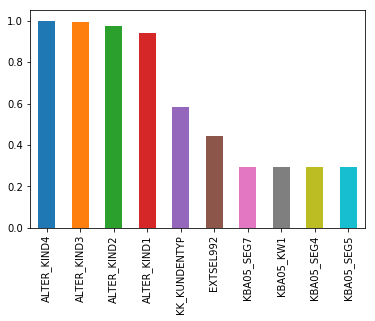

In [7]:
#cleaning cutomers
customers.isna().mean().sort_values(ascending=False).head(10).plot('bar')

In [8]:
customers.isna().mean().sort_values(ascending=False)>0.9

ALTER_KIND4                   True
ALTER_KIND3                   True
ALTER_KIND2                   True
ALTER_KIND1                   True
KK_KUNDENTYP                 False
EXTSEL992                    False
KBA05_SEG7                   False
KBA05_KW1                    False
KBA05_SEG4                   False
KBA05_SEG5                   False
KBA05_SEG6                   False
KBA05_MAXAH                  False
KBA05_SEG8                   False
KBA05_KW2                    False
KBA05_VORB0                  False
KBA05_KRSZUL                 False
KBA05_VORB1                  False
KBA05_KRSVAN                 False
KBA05_KRSOBER                False
KBA05_SEG9                   False
MOBI_REGIO                   False
KBA05_KW3                    False
KBA05_SEG3                   False
KBA05_KRSHERST3              False
KBA05_MAXBJ                  False
KBA05_MAXHERST               False
KBA05_MAXSEG                 False
KBA05_MAXVORB                False
KBA05_MOD1          

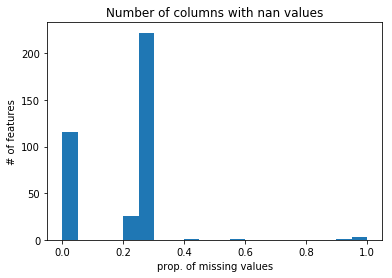

In [9]:
# finding number of columns with nan values
column_nan_perc = customers.isnull().mean()

plt.hist(column_nan_perc, bins = np.arange(0,1+.05,.05))
plt.ylabel('# of features')
plt.title('Number of columns with nan values')
plt.xlabel('prop. of missing values')
plt.show()

In [10]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [11]:
customers.dtypes.value_counts()

float64    267
int64       94
object       8
dtype: int64

In [12]:
#percentage of customer bought service
(customers[customers['ONLINE_PURCHASE']==1].shape[0] / customers['ONLINE_PURCHASE'].shape[0])*100

9.02469058501868

In [13]:
#common rows with most null

customers[(customers['KBA05_SEG3'].isnull()) | (customers['MOBI_REGIO'].isnull())].isnull().sum().sort_values(ascending=False)

KBA05_SEG3                   55980
KBA05_MAXVORB                55980
KBA05_MOD8                   55980
KBA05_MOD4                   55980
KBA05_MOD3                   55980
KBA05_MOD2                   55980
MOBI_REGIO                   55980
KBA05_MOD1                   55980
KBA05_MAXHERST               55980
KBA05_MOTRAD                 55980
KBA05_MAXBJ                  55980
KBA05_MAXAH                  55980
KBA05_KW3                    55980
KBA05_KW2                    55980
KBA05_KW1                    55980
KBA05_KRSZUL                 55980
KBA05_MOTOR                  55980
KBA05_SEG1                   55980
KBA05_KRSOBER                55980
KBA05_VORB0                  55980
KBA05_ZUL4                   55980
KBA05_ZUL3                   55980
KBA05_ZUL2                   55980
KBA05_ZUL1                   55980
KBA05_VORB2                  55980
KBA05_VORB1                  55980
KBA05_SEG9                   55980
KBA05_SEG10                  55980
KBA05_SEG8          

In [14]:
# % of null values in rows
customers.isnull().sum(axis=1).value_counts().sort_index().cumsum()/azdias.shape[0]*100

0       0.015260
1       0.072934
2       0.285675
3       0.749534
4       6.514995
5      11.907372
6      13.731948
7      14.198947
8      14.500893
9      14.584261
10     14.633520
11     14.678851
12     14.702863
13     14.714644
14     14.727772
15     14.786007
16     14.799360
17     14.810917
18     14.818771
19     14.819781
20     14.821240
21     14.822698
22     14.827187
23     14.836724
24     14.925927
25     14.993587
26     15.021527
27     15.051822
28     15.105793
29     15.140913
         ...    
219    15.902004
220    15.902116
221    15.904136
222    15.910532
223    15.933758
224    16.068517
225    16.197554
226    16.252086
227    16.261286
228    16.262857
229    16.262970
233    16.263082
234    16.263306
235    16.264540
236    16.265887
237    16.265999
238    16.266111
242    16.266224
243    16.266448
244    16.268916
245    16.270487
246    16.271385
247    16.272507
248    16.273741
249    16.275312
250    16.275649
252    16.907591
253    21.5039

### analysing the raw azdias file

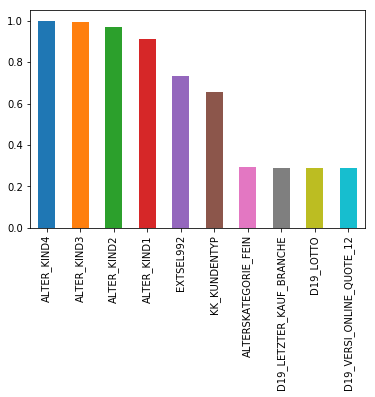

In [15]:
#cleaning azdias
azdias.isna().mean().sort_values(ascending=False).head(10).plot('bar')

In [16]:
azdias.isnull().mean().sort_values(ascending=False)

ALTER_KIND4                    0.998648
ALTER_KIND3                    0.993077
ALTER_KIND2                    0.966900
ALTER_KIND1                    0.909048
EXTSEL992                      0.733996
KK_KUNDENTYP                   0.655967
ALTERSKATEGORIE_FEIN           0.295041
D19_LETZTER_KAUF_BRANCHE       0.288495
D19_LOTTO                      0.288495
D19_VERSI_ONLINE_QUOTE_12      0.288495
D19_BANKEN_ONLINE_QUOTE_12     0.288495
D19_SOZIALES                   0.288495
D19_GESAMT_ONLINE_QUOTE_12     0.288495
D19_KONSUMTYP                  0.288495
D19_TELKO_ONLINE_QUOTE_12      0.288495
D19_VERSAND_ONLINE_QUOTE_12    0.288495
KBA05_MOTOR                    0.149597
KBA05_MOD8                     0.149597
KBA05_MOD4                     0.149597
KBA05_MOD3                     0.149597
KBA05_MOD2                     0.149597
KBA05_SEG1                     0.149597
KBA05_MOD1                     0.149597
KBA05_MAXVORB                  0.149597
KBA05_MAXSEG                   0.149597


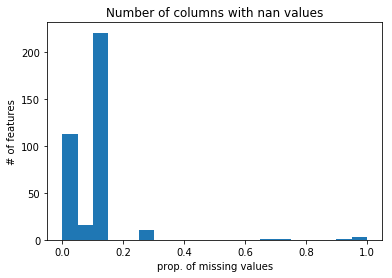

In [17]:
# finding number of columns with nan values
column_nan_perc = azdias.isnull().mean()

plt.hist(column_nan_perc, bins = np.arange(0,1+.05,.05))
plt.ylabel('# of features')
plt.title('Number of columns with nan values')
plt.xlabel('prop. of missing values')
plt.show()

In [18]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [19]:
# % of rows with the no. of missing values
azdias.isnull().sum(axis=1).value_counts().sort_index().cumsum()/azdias.shape[0]*100

0        0.033886
1        0.212293
2        0.996386
3        3.208856
4       16.583541
5       37.966228
6       56.098543
7       61.873654
8       63.318077
9       63.872934
10      64.066040
11      64.290114
12      64.518565
13      64.701685
14      65.184842
15      72.662336
16      82.272186
17      82.839498
18      83.348126
19      83.452589
20      83.515200
21      83.628752
22      83.731420
23      83.807271
24      83.888957
25      83.976702
26      84.033814
27      84.070057
28      84.145234
29      84.207733
          ...    
223     89.636241
224     89.954568
225     90.517279
226     91.010198
227     91.200611
228     91.211944
229     91.212842
231     91.213291
232     91.214637
233     91.217106
234     91.229673
235     91.428838
236     91.721021
237     91.740881
238     91.741779
241     91.741891
242     91.742003
243     91.742116
244     91.743911
245     91.745931
246     91.747838
247     91.748511
248     91.749746
249     91.750643
250     91

## Data Preprocessing

In [20]:
#as we can see from above data that there are many rows with many missing value so we can set a threshhold to remove the rows with max missing values such that we are keeping around 80% of data
azdias = azdias[azdias.isnull().sum(axis=1) <= 16].reset_index(drop=True)

print('Rows kept in new azdias dataset: ',azdias.shape[0])

Rows kept in new azdias dataset:  733227


In [21]:
# dropping columns with more that  65% of null vlaues

drop_cols = azdias.columns[column_nan_perc > 0.65]

azdias.drop(columns= drop_cols, inplace=True)

In [22]:
print('number of columns in new  azdias dataset: ',azdias.shape[1])

number of columns in new  azdias dataset:  360


In [23]:
#dropping the columns in the customers df to match it with azdias file

customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
customers.drop(drop_cols,axis=1, inplace=True)

In [24]:
#checking if columns are equal or not

customers.shape[1]==azdias.shape[1]

True

In [25]:
#number of rows in the new dataset

print("Rows in azdias: {}".format(azdias.shape[0]))
print("Rows in customers: {}".format(customers.shape[0]))

Rows in azdias: 733227
Rows in customers: 191652


In [26]:
# dropping the column D19_LETZTER_KAUF_BRANCHE & EINGEFUEGT_AM  as they have so many different values

azdias.drop(['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'],axis=1, inplace=True)
customers.drop(['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'],axis=1, inplace=True)

In [27]:
# Now I'm removing highly correlated columns to reduce the number of columns/features in our dataset. This approach has been followed # idea and approach from Chris Albon's website https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

# find correlation matrix 
print('number of columns before dropping in azdias: {}'.format(len(azdias.columns)))
azdias_corr_matrix = azdias.corr().abs()
upper_limit_azdias = azdias_corr_matrix.where(np.triu(np.ones(azdias_corr_matrix.shape), k=1).astype(np.bool))
# identify columns to drop based on threshold limit
drop_columns_azdias = [column for column in upper_limit_azdias.columns if any(upper_limit_azdias[column] > .7)]
# drop columns from azdias
azdias.drop(drop_columns_azdias, axis=1, inplace=True)
print('number of columns after dropping in azdias: {}'.format(len(azdias.columns)))



# repeating the same for customers df
print('number of columns before dropping in customer: {}'.format(len(customers.columns)))
customers_corr_matrix = customers.corr().abs()
upper_limit_customers = customers_corr_matrix.where(np.triu(np.ones(customers_corr_matrix.shape), k=1).astype(np.bool))
drop_columns_customers = [column for column in upper_limit_customers.columns if any(upper_limit_customers[column] > .7)]
customers.drop(drop_columns_customers, axis=1, inplace=True)
print('number of columns after dropping in customer: {}'.format(len(customers.columns)))



number of columns before dropping in azdias: 358
number of columns after dropping in azdias: 238
number of columns before dropping in customer: 358
number of columns after dropping in customer: 256


In [28]:
# columns with object data type

azdias.select_dtypes(include=['object']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,OST_WEST_KZ
0,8A,8,51,W
1,4C,4,24,W
2,2A,2,12,W
3,6B,6,43,W
4,8C,8,54,W


In [29]:
#finding the categorical field

all_columns_azdias = azdias.columns
numerical_columns_azdias = azdias._get_numeric_data().columns
print('num_cols: {}'.format(all_columns_azdias))
print('categorical: {}'.format(list(set(all_columns_azdias) - set(numerical_columns_azdias))))

num_cols: Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_TITEL',
       ...
       'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM',
       'VERS_TYP', 'VHA', 'VHN', 'W_KEIT_KIND_HH', 'WOHNLAGE', 'ZABEOTYP'],
      dtype='object', length=238)
categorical: ['CAMEO_INTL_2015', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [30]:
azdias[['CAMEO_DEUG_2015', 'OST_WEST_KZ', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']].head(5)

,CAMEO_DEUG_2015,OST_WEST_KZ,CAMEO_DEU_2015,CAMEO_INTL_2015
0,8,W,8A,51
1,4,W,4C,24
2,2,W,2A,12
3,6,W,6B,43
4,8,W,8C,54


In [31]:
#checking for the missing values in the columns: in this case X also denotes the missing value 
azdias['CAMEO_DEUG_2015'].value_counts()

8      74523
9      59226
6      57592
4      54348
8.0    53892
2      43712
3      43573
9.0    43108
7      42090
6.0    41974
4.0    39642
2.0    31759
3.0    31691
7.0    30814
5      28701
5.0    20532
1      19610
1.0    14219
X        270
Name: CAMEO_DEUG_2015, dtype: int64

In [32]:
# filling the missing values with -1
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace('X',-1)

In [33]:
#unique values
azdias['OST_WEST_KZ'].value_counts()

W    577348
O    155879
Name: OST_WEST_KZ, dtype: int64

In [34]:
#checking for the missing values in the columns: in this case XX also denotes the missing value 
azdias['CAMEO_DEU_2015'].value_counts()

6B    53163
8A    50274
4C    43279
2D    32407
7A    32136
3C    32132
3D    31853
8B    31468
8C    29804
4A    29658
9D    27180
9B    26287
9C    23776
7B    22976
9A    19760
2C    17496
8D    16869
6E    15427
5D    13928
6C    13900
2B    13871
2A    11697
1D    11325
1A    10027
5A     9548
5B     9516
5C     8896
7C     8513
4B     8138
4D     7974
6A     6342
6D     5713
3A     5691
3B     5588
9E     5331
6F     5021
7D     4944
4E     4941
1E     4711
7E     4335
5F     3996
1C     3979
1B     3787
5E     3349
XX      270
Name: CAMEO_DEU_2015, dtype: int64

In [35]:
# filling the missing values with -1
azdias['CAMEO_DEU_2015'] = azdias['CAMEO_DEU_2015'].replace('XX',-1)

In [36]:
#checking for the missing values in the columns: in this case XX also denotes the missing value 
azdias['CAMEO_INTL_2015'].value_counts()

51      74003
51.0    53514
41      50093
24      48391
41.0    36487
24.0    34994
14      33490
43      30680
54      24996
14.0    24179
43.0    22483
25      21167
54.0    18265
22      17054
25.0    15627
45      14439
13      13818
55      12825
22.0    12604
52      11392
23      11309
45.0    10344
13.0    10080
34      10017
55.0     9375
15       9271
31       9194
52.0     8368
23.0     8108
44       8005
34.0     7260
15.0     6765
12       6743
31.0     6696
44.0     5895
35       5702
32       5568
33       5218
12.0     4954
35.0     4007
32.0     3948
33.0     3678
XX        270
Name: CAMEO_INTL_2015, dtype: int64

In [37]:
# filling the missing values with -1
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace('XX',-1)

In [38]:
#replacing the same values in the same columns of the customer df
customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].replace('X',-1)
customers['CAMEO_DEU_2015'] = customers['CAMEO_DEU_2015'].replace('XX',-1)
customers['CAMEO_INTL_2015'] = customers['CAMEO_INTL_2015'].replace('XX',-1)

In [39]:
#checking for null values

azdias[['CAMEO_DEUG_2015', 'OST_WEST_KZ', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']].isnull().sum()

CAMEO_DEUG_2015    1951
OST_WEST_KZ           0
CAMEO_DEU_2015     1951
CAMEO_INTL_2015    1951
dtype: int64

In [40]:
# 3 columns has null values filling these values with -1
azdias[['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']].fillna(-1)
customers[['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']].fillna(-1)

In [41]:
# converting to int
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)

In [42]:
#converting the categorical variable by creating dummies
azdias = pd.get_dummies(azdias)
customers = pd.get_dummies(customers)

print('Shape of new azdias dataset: {}'.format(azdias.shape))
print('Shape of new customers dataset: {}'.format(customers.shape))

Shape of new azdias dataset: (733227, 283)
Shape of new customers dataset: (191652, 301)


In [43]:
col_azdias = azdias.columns
col_customers = customers.columns

In [44]:
col_customers

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_TITEL',
       ...
       'CAMEO_DEU_2015_8B', 'CAMEO_DEU_2015_8C', 'CAMEO_DEU_2015_8D',
       'CAMEO_DEU_2015_9A', 'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C',
       'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E', 'OST_WEST_KZ_O',
       'OST_WEST_KZ_W'],
      dtype='object', length=301)

In [45]:
#filling the nan values will mode

nan_imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)

new_azdias_df = nan_imputer.fit_transform(azdias)
new_azdias_df = pd.DataFrame(new_azdias_df)
print('imputed azdias: {}'.format(new_azdias_df.head(5)))

new_customers_df = nan_imputer.fit_transform(customers)
new_customers_df = pd.DataFrame(new_customers_df)
print('imputed customers: {}'.format(new_customers_df.head(5)))

imputed azdias:         0    1    2     3     4     5    6    7    8    9   ...   273  274  \
0  910220.0 -1.0  9.0   0.0  21.0  11.0  0.0  0.0  2.0  0.0 ...   0.0  0.0   
1  910225.0 -1.0  9.0  17.0  17.0  10.0  0.0  0.0  1.0  0.0 ...   0.0  0.0   
2  910226.0  2.0  1.0  13.0  13.0   1.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
3  910241.0 -1.0  1.0  20.0  14.0   3.0  0.0  0.0  4.0  0.0 ...   0.0  0.0   
4  910244.0  3.0  1.0  10.0  10.0   5.0  0.0  0.0  1.0  0.0 ...   0.0  1.0   

   275  276  277  278  279  280  281  282  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  

[5 rows x 283 columns]
imputed customers:         0    1    2     3     4    5    6    7    8    9   ...   291  292  \
0    9626.0  2.0  1.0  10.0  10.0  1.0  0.0  0.0  2.0  0.0 ...   0.0  0.0   
1    9628.0 -1.0  9.0  11.0  10.0  1.0  0.0  0.0  3.0 

In [46]:
#since all the columns now contains numerical value we will now change the data typ to int

azdias = new_azdias_df.astype(int)
customers = new_customers_df.astype(int)

**Checking & Removing outliers**

In [47]:
azdias = azdias[(np.abs(stats.zscore(azdias)) < 6).all(axis=1)]
customers = customers[(np.abs(stats.zscore(customers)) < 6).all(axis=1)]

**normalising data**

In [48]:
# normalising the data
azdias[azdias.columns] = StandardScaler(copy=False).fit_transform(azdias)
customers[customers.columns] = StandardScaler(copy=False).fit_transform(customers)

In [49]:
azdias.shape

(415998, 283)

**final function for pre processing data**

In [50]:
def data_cleaning(data_df, to_cluster, dfname=None):
    if to_cluster:
        if dfname == 'azdias':
            data_df = data_df[data_df.isnull().sum(axis=1) <= 16].reset_index(drop=True)
        elif dfname == 'customers':            
            data_df.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
    print("Dropping columns with more than 65% missing values")      
    columns_drop = ['EXTSEL992', 'KK_KUNDENTYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4']
    
    data_df = data_df.drop(columns_drop,axis=1)
    data_df = data_df.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)
    data_df = data_df.drop(['EINGEFUEGT_AM'],axis=1)
    
    print('column dropped')
    # computing the correlation matrix and dropping the correlated matrix
    print('Computing Correlation matrix')
    correlation_matrix = data_df.corr().abs()
    upper_limit_df = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
    drop_cols  = [col for col in upper_limit_df.columns if any(upper_limit_df[col] > .7)]
    data_df = data_df.drop(drop_cols, axis=1)
    print('shape after dropping the correlated columns: {}'.format(data_df.shape))
    
    #filling the missing and unknown values with -1 
    print('filling nan vlaues with -1')
    data_df[['CAMEO_INTL_2015', 'CAMEO_DEUG_2015']] = data_df[['CAMEO_INTL_2015', 'CAMEO_DEUG_2015']].replace(['X','XX'],-1)
    data_df[['CAMEO_INTL_2015', 'CAMEO_DEUG_2015']] = data_df[['CAMEO_INTL_2015', 'CAMEO_DEUG_2015']].fillna(-1)
    data_df[['CAMEO_INTL_2015', 'CAMEO_DEUG_2015']] = data_df[['CAMEO_INTL_2015', 'CAMEO_DEUG_2015']].astype(int)
    data_df[['OST_WEST_KZ', 'CAMEO_DEU_2015']] = data_df[['OST_WEST_KZ', 'CAMEO_DEU_2015']].fillna(-1)
    
     # filling na fields with 9 that has marked 9 as unknown
    data_df[data_df.columns[(data_df==9).any()]] = data_df[data_df.columns[(data_df==9).any()]].fillna(9)

    # filling na fields with 0 that has marked 0 as unknown
    data_df[data_df.columns[(data_df==0).any()]] = data_df[data_df.columns[(data_df==0).any()]].fillna(0)

    # filling na fields with -1 that has marked -1 as unknown
    data_df[data_df.columns[(data_df==-1).any()]] = data_df[data_df.columns[(data_df==-1).any()]].fillna(-1)
    
    print('values filled')
    #creating dummy variable for the categorical variables
    print('creating dummy variables')
    data_df = pd.get_dummies(data_df)
    print("Shape of df after creating dummy vairables: {}".format(data_df.shape))
    
    columns_df = list(data_df.columns.values)
    
    #imputing the nan value with mode
    print('Imputing nan values with mode')
    mode_imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
    data_df = mode_imputer.fit_transform(data_df)
    data_df = pd.DataFrame(data_df)
    print('shape after imputing the values', data_df.shape)
    
    #converting all values in df to int
    data_df = data_df.astype(int)
    
    #reomving outliers
    print('removing outliers')
    if to_cluster:
        print('Removing outliers')
        data_df = data_df[(np.abs(stats.zscore(data_df)) < 6).all(axis=1)] 
        
    

    print('Shape before normalising: {}'.format(data_df.shape))
    normalize = StandardScaler(copy=False).fit_transform(data_df)
    data_df = pd.DataFrame(normalize,columns= columns_df)
    print('Shape after normalising: {}'.format(data_df.shape))
        
    data_df = data_df.set_index('LNR')
    return data_df

In [51]:
azdias = data_cleaning(azdias_duplicate, True, 'azdias')
print("----------------------------------------------------------")
customers = data_cleaning(customers_duplicate, True, 'customers')

Dropping columns with more than 65% missing values
column dropped
Computing Correlation matrix
shape after dropping the correlated columns: (733227, 238)
filling nan vlaues with -1
values filled
creating dummy variables
Shape of df after creating dummy vairables: (733227, 284)
Imputing nan values with mode
shape after imputing the values (733227, 284)
removing outliers
Removing outliers
Shape before normalising: (415405, 284)
Shape after normalising: (415405, 284)
----------------------------------------------------------
Dropping columns with more than 65% missing values
column dropped
Computing Correlation matrix
shape after dropping the correlated columns: (191652, 256)
filling nan vlaues with -1
values filled
creating dummy variables
Shape of df after creating dummy vairables: (191652, 303)
Imputing nan values with mode
shape after imputing the values (191652, 303)
removing outliers
Removing outliers
Shape before normalising: (100341, 303)
Shape after normalising: (100341, 303)


with this we are done with cleaning the data. Now we use this data to analyse the relationships between the varialble

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

**To reduce the dimension of our data further we can now use PCA for dimension reduction. To decide the excat compomnets that we want to keep we can see the variance spread acroos the features and decide the number. We want our dataset to maintain a high vairance for better result**

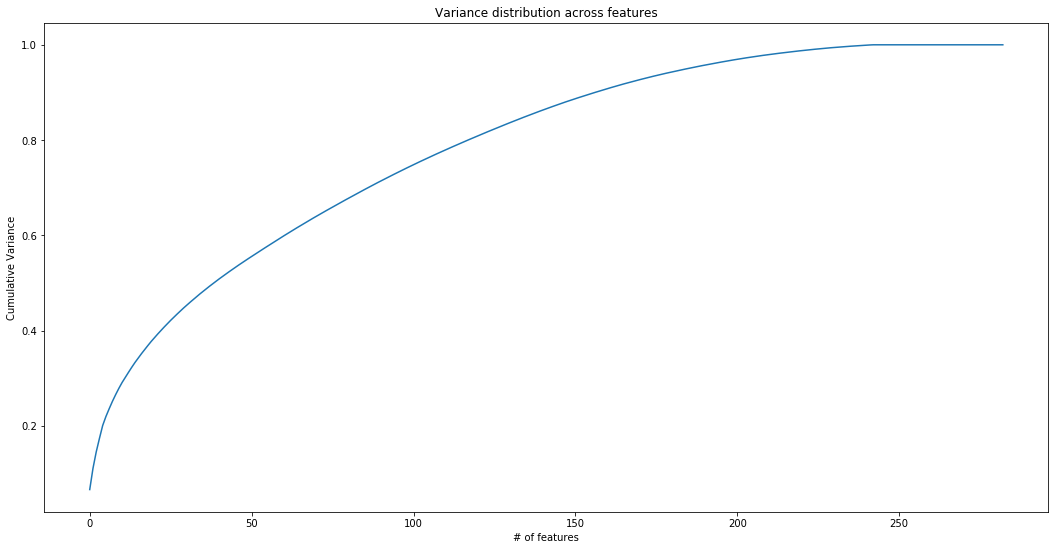

In [52]:
#plotting the graph for pca
pca_df = PCA().fit(azdias)
plt.figure(figsize=(18,9))
plt.plot(np.cumsum(pca_df.explained_variance_ratio_))
plt.xlabel('# of features')
plt.title("Variance distribution across features")
plt.ylabel('Cumulative Variance')
plt.show()

**as we can see from the graph that at 220 components we are getting high variance which is neccessary for keeping the critical information about the data. So now we will use PCA to reduce the dimension of df to 220.**

In [53]:
def dimension_reduction(df, n_component=220):
    pca_df = PCA(n_components=n_component).fit(df)
    dimension_reduction = pca_df.transform(df)
    dimension_reduction = pd.DataFrame(dimension_reduction)
    print("Variance of reduced dataset: {}".format(pca_df.explained_variance_ratio_.sum()))
    return dimension_reduction

In [54]:
#performind data reduction on dataset
azdias_pca = dimension_reduction(azdias)
customers_pca = dimension_reduction(customers)

Variance of reduced dataset: 0.9869700911960764
Variance of reduced dataset: 0.9973590461140331


In [55]:
#printing the new shape of our dataset
print('Shape of new azdias dataset: {}'.format(azdias_pca.shape))
print('Shape of new customer dataset: {}'.format(customers_pca.shape))

Shape of new azdias dataset: (415405, 220)
Shape of new customer dataset: (100341, 220)


In [56]:
azdias_pca.to_pickle('azdias_pca.p')
customers_pca.to_pickle('customers_pca.p')

In [57]:
#loading pickle file

azdias_pca = pd.read_pickle('azdias_pca.p')
customers_pca = pd.read_pickle('customers_pca.p')

### clustering

In [58]:
#defining the no. of clusters
def kmean_scores(X, k):
    kmeans = KMeans(k)
    kmeans_model = kmeans.fit(X)
    return abs(kmeans_model.score(X))

In [59]:
# checking the scores for different no. of clusters
accuracies = []

for i in range(1, 25):
    accuracies.append(kmean_scores(azdias_pca.sample(20000), i))


Text(0.5,1,' Distance within clusters vs No. of clusters')

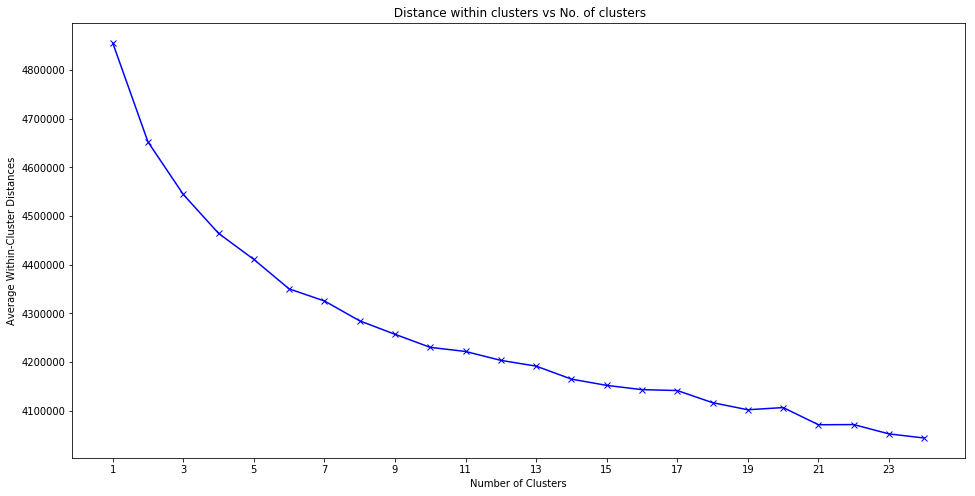

In [60]:
dots = np.linspace(1,24,24)
plt.figure(figsize=(16,8))
plt.plot(dots, accuracies, linestyle='-', marker='x', color='blue')
plt.xticks(list(range(1,25,2)))
plt.xlabel('Number of Clusters')
plt.ylabel('Average Within-Cluster Distances')
plt.title(" Distance within clusters vs No. of clusters")


**as we can see from the above chart that the average distance within the clusters almost flatterns at 16 number of cluters. So we will use 16 clusters for our analysis**

In [61]:
# making the model with 16 clusters

kmeans = KMeans(n_clusters = 16)
kmeans_model = kmeans.fit(azdias_pca)
azdias_prediction = kmeans_model.predict(azdias_pca)

In [62]:
#saving the prediction of our model in a pickle file

clustered_azdias = pd.DataFrame(azdias_prediction, columns = ['Cluster'])
#clustered_azdias.to_pickle('azdias_clustered')

In [63]:
# doing the same for customer dataset

customers_prediction = kmeans_model.predict(customers_pca)
clustered_customers = pd.DataFrame(customers_prediction, columns = ['Cluster'])
#clustered_customers.to_pickle('customers_clustered')


**analying and comparing the cluster between the general population and customers**

In [64]:
# counting no. of values in each clusters
cluster_cust = pd.Series(customers_prediction)
unique_val_cust = cluster_cust.value_counts().sort_index()

cluster_ppl = pd.Series(azdias_prediction)
unique_val_ppl = cluster_ppl.value_counts().sort_index()

#combining the two df

df_comb = pd.concat([unique_val_ppl, unique_val_cust], axis=1).reset_index()
df_comb.columns = ['Cluster No','Values in poplutation','Values in customer']

df_comb['difference'] = (df_comb['Values in customer']/df_comb['Values in customer'].sum()*100) - (df_comb['Values in poplutation']/df_comb['Values in poplutation'].sum()*100)
df_comb

,Cluster No,Values in poplutation,Values in customer,difference
0,0,37349,61,-8.930192
1,1,30267,10084,2.763588
2,2,23515,724,-4.939201
3,3,23391,77,-5.554152
4,4,39994,316,-9.312787
5,5,24451,44880,38.841416
6,6,31986,23,-7.677034
7,7,33281,6999,-1.036485
8,8,17707,67,-4.195815
9,9,9003,2030,-0.144181


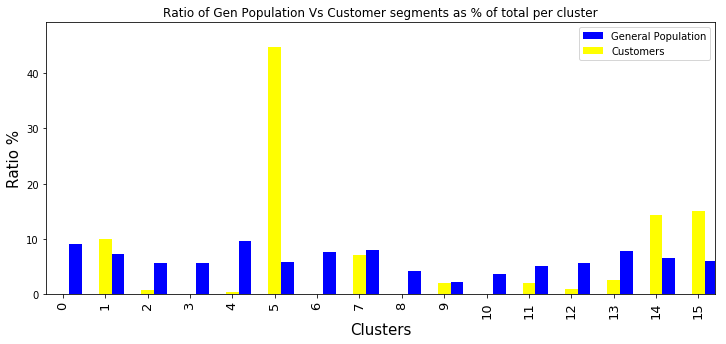

In [65]:
df_comb['pop_percent'] = (df_comb['Values in poplutation']/df_comb['Values in poplutation'].sum()*100).round(2)
df_comb['cust_percent'] = (df_comb['Values in customer']/df_comb['Values in customer'].sum()*100).round(2)


fig = plt.figure(figsize=(12,5))

axes = fig.add_subplot(111)
axes = df_comb['pop_percent'].plot(x=df_comb['Cluster No'], color='blue', width=0.3, align='edge', kind='bar',position=0)
axes = df_comb['cust_percent'].plot(kind='bar',color='yellow',width = 0.3, align='edge',position=1)
axes.set_ylabel('Ratio %', fontsize=15)
axes.set_xlabel('Clusters', fontsize=15) 
axes.tick_params(axis = 'x', which = 'major', labelsize = 13)
axes.xaxis.set(ticklabels=range(20))
axes.margins(x=0.5,y=0.1)

plt.legend(('General Population', 'Customers'))
plt.title(('Ratio of Gen Population Vs Customer segments as % of total per cluster'))
plt.show()

In [66]:
df_comb.head()

,Cluster No,Values in poplutation,Values in customer,difference,pop_percent,cust_percent
0,0,37349,61,-8.930192,8.99,0.06
1,1,30267,10084,2.763588,7.29,10.05
2,2,23515,724,-4.939201,5.66,0.72
3,3,23391,77,-5.554152,5.63,0.08
4,4,39994,316,-9.312787,9.63,0.31


In [67]:
# Showing the Highest Positive and Negative weights when a PComponent and Weight is passed
def weights_pca(pc , weight_num, pca_df):
    ratio_variance = pd.DataFrame(pca_df.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio_variance = ratio_variance.round(3)
    weights_azdias = pd.DataFrame(pca_df.components_, columns = azdias.columns.values)
    weights_azdias = weights_azdias.round(3)    
    
    final_result = pd.concat([ratio_variance, weights_azdias], axis = 1,  join_axes=[ratio_variance.index])
    final_result[:5]
    print("No. of Principal Component: ", (pc))    
    print('\n')
    print("Maximum Positive weights:")
    print(final_result.iloc[(pc)-1].sort_values(ascending=False)[:weight_num])
    print('\n')
    print("Maximum Negative weights:")
    print(final_result.iloc[(pc)-1].sort_values()[:weight_num])
    

pca_df = PCA().fit(azdias)


In [68]:
weights_pca(15,5,pca_df)

No. of Principal Component:  15


Maximum Positive weights:
KBA13_VORB_0        0.252
KBA05_ZUL1          0.246
KBA13_KRSZUL_NEU    0.227
KBA13_BJ_2008       0.198
KBA13_BJ_2009       0.187
Name: 14, dtype: float64


Maximum Negative weights:
KBA13_VORB_1_2    -0.304
KBA13_BJ_2004     -0.230
KBA05_MAXBJ       -0.211
KBA05_ZUL2        -0.162
RT_SCHNAEPPCHEN   -0.158
Name: 14, dtype: float64


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [69]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [70]:
X = mailout_train.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']

In [71]:
X.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,1.0,6.0,4.0,2.0,NaN,9.0,2.0,3,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,1,3


In [72]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: RESPONSE, dtype: int64

In [73]:
%%time
df_train  = data_cleaning(X, False)

Dropping columns with more than 65% missing values
column dropped
Computing Correlation matrix
shape after dropping the correlated columns: (42962, 253)
filling nan vlaues with -1
values filled
creating dummy variables
Shape of df after creating dummy vairables: (42962, 300)
Imputing nan values with mode
shape after imputing the values (42962, 300)
removing outliers
Shape before normalising: (42962, 300)
Shape after normalising: (42962, 300)
CPU times: user 20.9 s, sys: 1.92 s, total: 22.8 s
Wall time: 58.2 s


In [74]:
df_train.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,OST_WEST_KZ_-1,OST_WEST_KZ_O,OST_WEST_KZ_W
LNR,,,,,,,,,,,,,,,,,,,,,
-1.656309,1.031262,-0.545883,-0.371726,-0.428455,0.573402,-0.499090,-0.204857,-0.752038,-0.083831,-0.459891,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.47014,-0.494196,0.778419
-1.655987,0.323502,0.396516,0.523127,0.837103,-0.445506,-0.499090,-0.204857,-0.402222,-0.083831,-0.860749,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.47014,-0.494196,0.778419
-1.655785,0.323502,-0.545883,-0.192755,-0.681567,-0.518285,2.042255,-0.204857,-1.101855,-0.083831,-0.059034,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.47014,2.023489,-1.284655
-1.668538,1.031262,-0.545883,-0.729667,-0.934679,-0.227168,-0.499090,-0.204857,-0.402222,-0.083831,-0.059034,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.47014,-0.494196,0.778419
-1.655502,1.031262,-0.545883,-0.192755,-0.175344,3.339007,-0.499090,-0.204857,-0.752038,-0.083831,-0.459891,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.47014,-0.494196,0.778419


In [75]:
#slpitting the dataset into training and testing
X_train, X_val, y_train, y_val = train_test_split(df_train, y, test_size=0.2, stratify=y, random_state=42)

In [76]:
%%time
# Some basic training use LGBMRegressor
regressor = lgb.LGBMRegressor(
            learning_rate=0.001, 
            lambda_l2 = 0.1,
            n_estimators=6000
        )

classfier = lgb.LGBMRegressor(random_state=0)
parm = {'learning_rate' : [0.01, 0.001, 0.001],
        'n_estimators' : [100, 500, 1000, 2000],
        'max_depth': [3, 5, 10]
       }

# Performing grid search
cv_obj = GridSearchCV(classfier, parm, scoring = 'roc_auc')

# Fit the model
cv_fit = cv_obj.fit(X_train, y_train)

# Get the estimator and predict
best_classfier = cv_fit.best_estimator_
normal_predictions = (classfier.fit(X_train, y_train)).predict(X_val)
best_clf_predictions = best_classfier.predict(X_val)

# Report the before-and-afterscores
print("Unoptimized Model Prediction")
print("ROC score on testing data: {:.6f}".format(roc_auc_score(y_val, normal_predictions)))
print("-----------------------------------------------------------------------")
print("Best Model Prdictions")
print("ROC score on testing data: {:.6f}".format(roc_auc_score(y_val, best_clf_predictions)))
print("-----------------------------------------------------------------------")
print(cv_fit.best_params_)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1237, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 18, in <module>
  File "/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py", line 639, in fit
    cv.split(X, y, groups)))
  File "/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/opt/conda/lib/python3.6/site-pac

KeyboardInterrupt: 

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [57]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [66]:
print("Shape of test before cleaning: {}".format(mailout_test.shape))
test_clean = data_cleaning(mailout_test, False)
print("Shape of test after cleaning: {}".format(test_clean.shape))

Shape of test before cleaning: (42833, 366)
Dropping columns with more than 65% missing values
column dropped
Computing Correlation matrix
shape after dropping the correlated columns: (42833, 253)
filling nan vlaues with -1
values filled
creating dummy variables
Shape of df after creating dummy vairables: (42833, 300)
Imputing nan values with mode
shape after imputing the values (42833, 300)
removing outliers
Shape before normalising: (42833, 300)
Shape after normalising: (42833, 300)
Shape of test after cleaning: (42833, 299)


In [67]:
kaggle_prediction = best_classfier.predict(test_clean)

In [68]:
kaggle_submission = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=kaggle_prediction)
kaggle_submission.rename(columns={0: "RESPONSE"}, inplace=True)

In [69]:
kaggle_submission.head(10)

,RESPONSE
LNR,
1754,0.017549
1770,0.030563
1465,0.009816
1470,0.009816
1478,0.009816
1782,0.009816
1485,0.008746
1519,0.012388
1835,0.020385


In [71]:
kaggle_submission.to_csv('arvato_submission.csv')